# Miniproject 1: Image Classification

## Introduction

### Important dates:

- Project release: Friday, 15th March 2019
- **Submission deadline**: Monday, 29th April 2019, 11:59 pm

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://yann.lecun.com/exdb/mnist/). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used as a first test for new classification algorithms. 
We follow this tradition to investigate the performance of artificial neural networks of different complexity on MNIST. However, since MNIST is too easy for accessing the full power of modern machine learning algorithms (see e.g. [this post](https://twitter.com/goodfellow_ian/status/852591106655043584)) we will extend our analysis to the recently introduced, harder [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/). Feel free to gain inspiration from the [Keras example directory](https://github.com/keras-team/keras/tree/master/examples) for your implementations.
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "convolutional neural network", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night (or on an external server).

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. Provide clear and concise answers respecting the indicated maximum length (answers to the questions should be below the line that says "Answer to question ...").

**The submitted notebook must be run by you!** We will only do random tests of your code and not re-run the full notebook. There will be fraud detection sessions at the end of the semester.

### Your names

**Before you start**: please enter your full name(s) in the field below.

In [1]:
student1 = "Doga Tekin"
student2 = "Serif Soner Serbest"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [13]:
%matplotlib inline

import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation
from keras.optimizers import SGD, Adam

### Plotting

In [71]:
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j])%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k])%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig


## Exercise 1: Data import and visualization (4 points)

### Description

### Loading the data

The datasets we use in this project (MNIST, Fashion-MNIST) consists of grayscale images with 28x28 pixels. Keras comes with a convenient in-built [data importer](https://keras.io/datasets/) for common datasets.

1. As a warm-up exercise, use this importer to (down-)load the MNIST and Fashion-MNIST dataset. Assign useful variables to test & train images and labels for both datasets respectively. (2 pts)
2. Use the corresponding plotting function defined above to plot some samples of the two datasets. What do the green digits at the bottom left of each image indicate? (1 sentence max.) (2 pts)

The low resolution (and grayscale) of the images certainly misses some information that could be helpful for classifying the images. However, since the data has lower dimensionality due to the low resolution, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish.



### Solution

In [4]:
from keras.datasets import mnist, fashion_mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()

Answer to question 2:

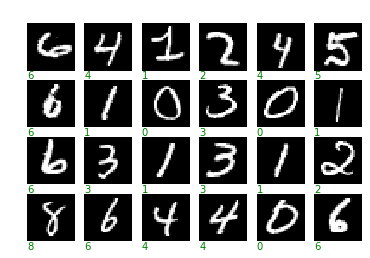

In [72]:
plot_some_samples(x_train, y_train);

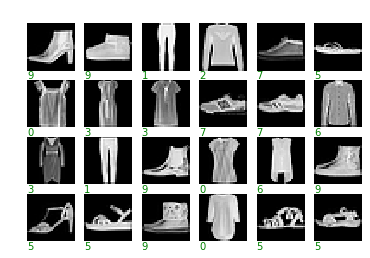

In [73]:
plot_some_samples(x_fashion_train, y_fashion_train);

The green digits indicate the mapped versions of the correct labels of each image by adding one and taking modulo 10.

**Data pre-processing**: To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing). Furthermore we reshape (flatten) the input images to input vectors and rescale the data into the range [0,1].

In [7]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

y_fashion_train = keras.utils.to_categorical(y_fashion_train)
y_fashion_test = keras.utils.to_categorical(y_fashion_test)

In [8]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])/np.max(x_train)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])/np.max(x_test)

x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], x_fashion_train.shape[1]*x_fashion_train.shape[2])/np.max(x_fashion_train)
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], x_fashion_test.shape[1]*x_fashion_test.shape[2])/np.max(x_fashion_test)

## Exercise 2: No hidden layer (10 points)

### Description

Define and fit a model without a hidden layer (since we will use multi-layer models later in this project, you can define a general constructor function for models with an arbitrary number of hidden layers already at this point). (1 pt for each step)

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices)`. Explain the green and red digits at the bottom of each image.
9. Repeat the above steps for fitting the network to the Fashion-MNIST dataset.


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

#### MNIST

In [18]:
model = Sequential([
    Dense(10, input_shape=(784,)),
    Activation('softmax')
])

In [19]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
# TODO: try validation_split instead of validation_data
history = model.fit(x_train, y_train, batch_size=128, epochs=500, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.2675 - acc: 0.9259 - val_loss: 0.2712 - val_acc: 0.9239
Epoch 2/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.2673 - acc: 0.9259 - val_loss: 0.2714 - val_acc: 0.9231
Epoch 3/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.2673 - acc: 0.9258 - val_loss: 0.2713 - val_acc: 0.9237
Epoch 4/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.2672 - acc: 0.9258 - val_loss: 0.2713 - val_acc: 0.9235
Epoch 5/500
60000/60000 [==============================] - 1s 10us/step - loss: 0.2671 - acc: 0.9260 - val_loss: 0.2714 - val_acc: 0.9234
Epoch 6/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.2670 - acc: 0.9260 - val_loss: 0.2711 - val_acc: 0.9230
Epoch 7/500
60000/60000 [==============================] - 0s 7us/step - loss: 0.2669 - acc: 0.9261 - val_loss: 0.2711 - val_ac

60000/60000 [==============================] - 1s 8us/step - loss: 0.2629 - acc: 0.9271 - val_loss: 0.2692 - val_acc: 0.9231
Epoch 61/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.2628 - acc: 0.9274 - val_loss: 0.2694 - val_acc: 0.9235
Epoch 62/500
60000/60000 [==============================] - 0s 7us/step - loss: 0.2628 - acc: 0.9271 - val_loss: 0.2693 - val_acc: 0.9235
Epoch 63/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.2627 - acc: 0.9276 - val_loss: 0.2691 - val_acc: 0.9234
Epoch 64/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.2626 - acc: 0.9272 - val_loss: 0.2692 - val_acc: 0.9238
Epoch 65/500
60000/60000 [==============================] - 0s 7us/step - loss: 0.2625 - acc: 0.9272 - val_loss: 0.2694 - val_acc: 0.9239
Epoch 66/500
60000/60000 [==============================] - 0s 7us/step - loss: 0.2625 - acc: 0.9272 - val_loss: 0.2691 - val_acc: 0.9235
Epoch 67/500
60000/60000 [=====================

60000/60000 [==============================] - 1s 8us/step - loss: 0.2594 - acc: 0.9282 - val_loss: 0.2680 - val_acc: 0.9241
Epoch 120/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.2594 - acc: 0.9284 - val_loss: 0.2681 - val_acc: 0.9239
Epoch 121/500
60000/60000 [==============================] - 0s 7us/step - loss: 0.2593 - acc: 0.9286 - val_loss: 0.2681 - val_acc: 0.9240
Epoch 122/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.2592 - acc: 0.9284 - val_loss: 0.2681 - val_acc: 0.9239
Epoch 123/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.2592 - acc: 0.9285 - val_loss: 0.2677 - val_acc: 0.9241
Epoch 124/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.2592 - acc: 0.9286 - val_loss: 0.2678 - val_acc: 0.9243
Epoch 125/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.2591 - acc: 0.9284 - val_loss: 0.2680 - val_acc: 0.9244
Epoch 126/500
60000/60000 [==============

Epoch 178/500
60000/60000 [==============================] - 1s 10us/step - loss: 0.2566 - acc: 0.9294 - val_loss: 0.2670 - val_acc: 0.9238
Epoch 179/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.2566 - acc: 0.9293 - val_loss: 0.2670 - val_acc: 0.9241
Epoch 180/500
60000/60000 [==============================] - 1s 10us/step - loss: 0.2565 - acc: 0.9296 - val_loss: 0.2672 - val_acc: 0.9239
Epoch 181/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.2565 - acc: 0.9294 - val_loss: 0.2672 - val_acc: 0.9242
Epoch 182/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.2565 - acc: 0.9294 - val_loss: 0.2670 - val_acc: 0.9239
Epoch 183/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.2564 - acc: 0.9296 - val_loss: 0.2669 - val_acc: 0.9239
Epoch 184/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.2564 - acc: 0.9295 - val_loss: 0.2670 - val_acc: 0.9241
Epoch 185/500
60000/60000

Epoch 237/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.2543 - acc: 0.9301 - val_loss: 0.2665 - val_acc: 0.9238
Epoch 238/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.2543 - acc: 0.9302 - val_loss: 0.2664 - val_acc: 0.9241
Epoch 239/500
60000/60000 [==============================] - 1s 10us/step - loss: 0.2543 - acc: 0.9303 - val_loss: 0.2664 - val_acc: 0.9244
Epoch 240/500
60000/60000 [==============================] - 1s 10us/step - loss: 0.2542 - acc: 0.9301 - val_loss: 0.2664 - val_acc: 0.9239
Epoch 241/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.2542 - acc: 0.9301 - val_loss: 0.2665 - val_acc: 0.9242
Epoch 242/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.2542 - acc: 0.9302 - val_loss: 0.2663 - val_acc: 0.9245
Epoch 243/500
60000/60000 [==============================] - 1s 10us/step - loss: 0.2541 - acc: 0.9302 - val_loss: 0.2664 - val_acc: 0.9239
Epoch 244/500
60000/6000

Epoch 296/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.2524 - acc: 0.9307 - val_loss: 0.2660 - val_acc: 0.9245
Epoch 297/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.2523 - acc: 0.9307 - val_loss: 0.2658 - val_acc: 0.9250
Epoch 298/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.2523 - acc: 0.9308 - val_loss: 0.2656 - val_acc: 0.9246
Epoch 299/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.2523 - acc: 0.9310 - val_loss: 0.2658 - val_acc: 0.9244
Epoch 300/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.2523 - acc: 0.9308 - val_loss: 0.2657 - val_acc: 0.9246
Epoch 301/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.2522 - acc: 0.9309 - val_loss: 0.2659 - val_acc: 0.9245
Epoch 302/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.2522 - acc: 0.9309 - val_loss: 0.2656 - val_acc: 0.9246
Epoch 303/500
60000/60000 [

Epoch 355/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.2507 - acc: 0.9313 - val_loss: 0.2653 - val_acc: 0.9245
Epoch 356/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.2507 - acc: 0.9313 - val_loss: 0.2653 - val_acc: 0.9245
Epoch 357/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.2506 - acc: 0.9313 - val_loss: 0.2654 - val_acc: 0.9245
Epoch 358/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.2506 - acc: 0.9311 - val_loss: 0.2655 - val_acc: 0.9247
Epoch 359/500
60000/60000 [==============================] - 0s 7us/step - loss: 0.2506 - acc: 0.9314 - val_loss: 0.2656 - val_acc: 0.9246
Epoch 360/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.2505 - acc: 0.9313 - val_loss: 0.2656 - val_acc: 0.9246
Epoch 361/500
60000/60000 [==============================] - 1s 11us/step - loss: 0.2505 - acc: 0.9314 - val_loss: 0.2653 - val_acc: 0.9247
Epoch 362/500
60000/60000 

Epoch 414/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.2492 - acc: 0.9317 - val_loss: 0.2651 - val_acc: 0.9248
Epoch 415/500
60000/60000 [==============================] - 0s 7us/step - loss: 0.2492 - acc: 0.9317 - val_loss: 0.2651 - val_acc: 0.9247
Epoch 416/500
60000/60000 [==============================] - 1s 10us/step - loss: 0.2491 - acc: 0.9316 - val_loss: 0.2650 - val_acc: 0.9250
Epoch 417/500
60000/60000 [==============================] - 1s 10us/step - loss: 0.2491 - acc: 0.9315 - val_loss: 0.2651 - val_acc: 0.9249
Epoch 418/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.2491 - acc: 0.9318 - val_loss: 0.2650 - val_acc: 0.9250
Epoch 419/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.2491 - acc: 0.9318 - val_loss: 0.2650 - val_acc: 0.9253
Epoch 420/500
60000/60000 [==============================] - 1s 10us/step - loss: 0.2491 - acc: 0.9319 - val_loss: 0.2651 - val_acc: 0.9246
Epoch 421/500
60000/6000

Epoch 473/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.2479 - acc: 0.9321 - val_loss: 0.2649 - val_acc: 0.9251
Epoch 474/500
60000/60000 [==============================] - 1s 10us/step - loss: 0.2479 - acc: 0.9321 - val_loss: 0.2648 - val_acc: 0.9254
Epoch 475/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.2478 - acc: 0.9321 - val_loss: 0.2647 - val_acc: 0.9258
Epoch 476/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.2478 - acc: 0.9319 - val_loss: 0.2649 - val_acc: 0.9250
Epoch 477/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.2478 - acc: 0.9320 - val_loss: 0.2648 - val_acc: 0.9252
Epoch 478/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.2478 - acc: 0.9320 - val_loss: 0.2649 - val_acc: 0.9250
Epoch 479/500
60000/60000 [==============================] - 0s 7us/step - loss: 0.2478 - acc: 0.9320 - val_loss: 0.2650 - val_acc: 0.9250
Epoch 480/500
60000/60000 

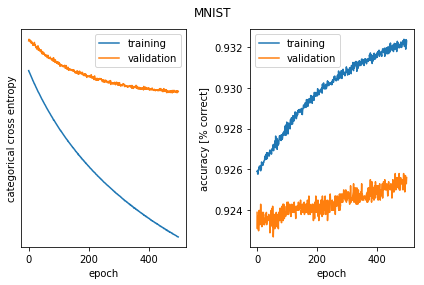

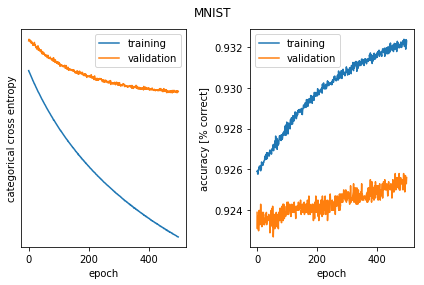

In [28]:
plot_history(history, 'MNIST')

In [67]:
yhat_test = model.predict_classes(x_test)
labels = y_test.argmax(axis=1)

error_indices = np.where(yhat_test != labels)[0]

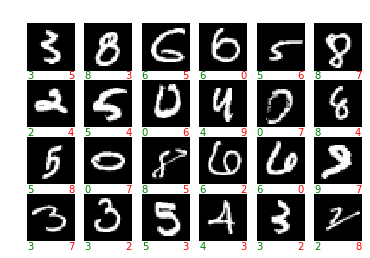

In [74]:
plot_some_samples(x_test, labels, yhat_test, error_indices);

The green digits are the true classes of the digits and the red digits are the predictions of our network.

#### Fashion-MNIST

In [75]:
model = Sequential([
    Dense(10, input_shape=(784,)),
    Activation('softmax')
])

In [76]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [77]:
history = model.fit(x_fashion_train, y_fashion_train, batch_size=128, epochs=500, 
                    validation_data=(x_fashion_test, y_fashion_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/500
60000/60000 [==============================] - 1s 10us/step - loss: 1.1606 - acc: 0.6437 - val_loss: 0.8729 - val_acc: 0.7090
Epoch 2/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.7823 - acc: 0.7490 - val_loss: 0.7472 - val_acc: 0.7505
Epoch 3/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.6959 - acc: 0.7781 - val_loss: 0.6889 - val_acc: 0.7697
Epoch 4/500
60000/60000 [==============================] - 0s 7us/step - loss: 0.6490 - acc: 0.7930 - val_loss: 0.6525 - val_acc: 0.7830
Epoch 5/500
60000/60000 [==============================] - 1s 10us/step - loss: 0.6180 - acc: 0.8023 - val_loss: 0.6281 - val_acc: 0.7910
Epoch 6/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.5954 - acc: 0.8079 - val_loss: 0.6095 - val_acc: 0.7970
Epoch 7/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.5779 - acc: 0.8130 - val_loss: 0.5947 - val_a

Epoch 60/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.4338 - acc: 0.8531 - val_loss: 0.4698 - val_acc: 0.8367
Epoch 61/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.4331 - acc: 0.8539 - val_loss: 0.4694 - val_acc: 0.8377
Epoch 62/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.4323 - acc: 0.8542 - val_loss: 0.4709 - val_acc: 0.8360
Epoch 63/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.4317 - acc: 0.8543 - val_loss: 0.4684 - val_acc: 0.8377
Epoch 64/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.4311 - acc: 0.8547 - val_loss: 0.4691 - val_acc: 0.8364
Epoch 65/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.4306 - acc: 0.8541 - val_loss: 0.4690 - val_acc: 0.8365
Epoch 66/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.4301 - acc: 0.8546 - val_loss: 0.4674 - val_acc: 0.8383
Epoch 67/500
60000/60000 [========

60000/60000 [==============================] - 1s 10us/step - loss: 0.4098 - acc: 0.8606 - val_loss: 0.4519 - val_acc: 0.8427
Epoch 120/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.4096 - acc: 0.8608 - val_loss: 0.4519 - val_acc: 0.8419
Epoch 121/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.4094 - acc: 0.8611 - val_loss: 0.4521 - val_acc: 0.8417
Epoch 122/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.4090 - acc: 0.8608 - val_loss: 0.4512 - val_acc: 0.8424
Epoch 123/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.4089 - acc: 0.8607 - val_loss: 0.4512 - val_acc: 0.8419
Epoch 124/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.4086 - acc: 0.8615 - val_loss: 0.4507 - val_acc: 0.8427
Epoch 125/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.4083 - acc: 0.8607 - val_loss: 0.4510 - val_acc: 0.8417
Epoch 126/500
60000/60000 [=============

Epoch 178/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.3985 - acc: 0.8642 - val_loss: 0.4446 - val_acc: 0.8443
Epoch 179/500
60000/60000 [==============================] - 0s 7us/step - loss: 0.3983 - acc: 0.8638 - val_loss: 0.4449 - val_acc: 0.8442
Epoch 180/500
60000/60000 [==============================] - 1s 10us/step - loss: 0.3982 - acc: 0.8646 - val_loss: 0.4448 - val_acc: 0.8423
Epoch 181/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.3981 - acc: 0.8638 - val_loss: 0.4442 - val_acc: 0.8437
Epoch 182/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.3979 - acc: 0.8637 - val_loss: 0.4447 - val_acc: 0.8433
Epoch 183/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.3977 - acc: 0.8644 - val_loss: 0.4448 - val_acc: 0.8427
Epoch 184/500
60000/60000 [==============================] - 1s 10us/step - loss: 0.3974 - acc: 0.8639 - val_loss: 0.4450 - val_acc: 0.8434
Epoch 185/500
60000/60000

60000/60000 [==============================] - 1s 12us/step - loss: 0.3914 - acc: 0.8658 - val_loss: 0.4406 - val_acc: 0.8446
Epoch 237/500
60000/60000 [==============================] - 1s 11us/step - loss: 0.3913 - acc: 0.8658 - val_loss: 0.4402 - val_acc: 0.8449
Epoch 238/500
60000/60000 [==============================] - 1s 12us/step - loss: 0.3910 - acc: 0.8657 - val_loss: 0.4405 - val_acc: 0.8446
Epoch 239/500
60000/60000 [==============================] - 1s 13us/step - loss: 0.3911 - acc: 0.8664 - val_loss: 0.4401 - val_acc: 0.8446
Epoch 240/500
60000/60000 [==============================] - 1s 11us/step - loss: 0.3908 - acc: 0.8666 - val_loss: 0.4405 - val_acc: 0.8431
Epoch 241/500
60000/60000 [==============================] - 1s 11us/step - loss: 0.3908 - acc: 0.8660 - val_loss: 0.4412 - val_acc: 0.8446
Epoch 242/500
60000/60000 [==============================] - 1s 13us/step - loss: 0.3907 - acc: 0.8657 - val_loss: 0.4406 - val_acc: 0.8436
Epoch 243/500
60000/60000 [=======

60000/60000 [==============================] - 1s 10us/step - loss: 0.3863 - acc: 0.8674 - val_loss: 0.4379 - val_acc: 0.8459
Epoch 295/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.3862 - acc: 0.8672 - val_loss: 0.4380 - val_acc: 0.8449
Epoch 296/500
60000/60000 [==============================] - 1s 10us/step - loss: 0.3861 - acc: 0.8673 - val_loss: 0.4390 - val_acc: 0.8436
Epoch 297/500
60000/60000 [==============================] - 1s 10us/step - loss: 0.3860 - acc: 0.8671 - val_loss: 0.4385 - val_acc: 0.8450
Epoch 298/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.3859 - acc: 0.8676 - val_loss: 0.4394 - val_acc: 0.8442
Epoch 299/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.3858 - acc: 0.8678 - val_loss: 0.4382 - val_acc: 0.8450
Epoch 300/500
60000/60000 [==============================] - 1s 10us/step - loss: 0.3858 - acc: 0.8669 - val_loss: 0.4378 - val_acc: 0.8444
Epoch 301/500
60000/60000 [==========

Epoch 353/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.3822 - acc: 0.8685 - val_loss: 0.4365 - val_acc: 0.8450
Epoch 354/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.3822 - acc: 0.8688 - val_loss: 0.4366 - val_acc: 0.8453
Epoch 355/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.3820 - acc: 0.8688 - val_loss: 0.4365 - val_acc: 0.8450
Epoch 356/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.3821 - acc: 0.8685 - val_loss: 0.4367 - val_acc: 0.8437
Epoch 357/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.3819 - acc: 0.8686 - val_loss: 0.4363 - val_acc: 0.8450
Epoch 358/500
60000/60000 [==============================] - 1s 10us/step - loss: 0.3819 - acc: 0.8686 - val_loss: 0.4367 - val_acc: 0.8451
Epoch 359/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.3818 - acc: 0.8685 - val_loss: 0.4363 - val_acc: 0.8458
Epoch 360/500
60000/60000 

Epoch 412/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.3790 - acc: 0.8691 - val_loss: 0.4366 - val_acc: 0.8453
Epoch 413/500
60000/60000 [==============================] - 1s 10us/step - loss: 0.3789 - acc: 0.8690 - val_loss: 0.4353 - val_acc: 0.8453
Epoch 414/500
60000/60000 [==============================] - 1s 10us/step - loss: 0.3787 - acc: 0.8691 - val_loss: 0.4368 - val_acc: 0.8452
Epoch 415/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.3788 - acc: 0.8698 - val_loss: 0.4355 - val_acc: 0.8452
Epoch 416/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.3788 - acc: 0.8697 - val_loss: 0.4355 - val_acc: 0.8448
Epoch 417/500
60000/60000 [==============================] - 1s 10us/step - loss: 0.3785 - acc: 0.8693 - val_loss: 0.4375 - val_acc: 0.8452
Epoch 418/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.3785 - acc: 0.8698 - val_loss: 0.4357 - val_acc: 0.8453
Epoch 419/500
60000/6000

Epoch 471/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.3763 - acc: 0.8701 - val_loss: 0.4360 - val_acc: 0.8447
Epoch 472/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.3763 - acc: 0.8702 - val_loss: 0.4351 - val_acc: 0.8462
Epoch 473/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.3762 - acc: 0.8701 - val_loss: 0.4349 - val_acc: 0.8456
Epoch 474/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.3762 - acc: 0.8698 - val_loss: 0.4347 - val_acc: 0.8455
Epoch 475/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.3761 - acc: 0.8703 - val_loss: 0.4351 - val_acc: 0.8454
Epoch 476/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.3760 - acc: 0.8705 - val_loss: 0.4347 - val_acc: 0.8455
Epoch 477/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.3760 - acc: 0.8698 - val_loss: 0.4360 - val_acc: 0.8434
Epoch 478/500
60000/60000 [

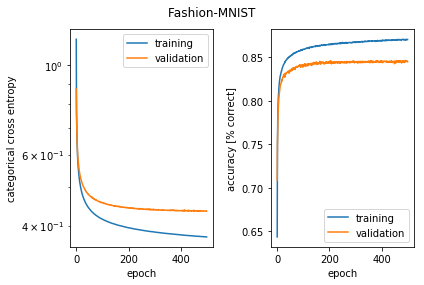

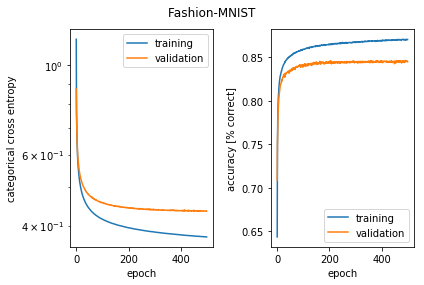

In [78]:
plot_history(history, 'Fashion-MNIST')

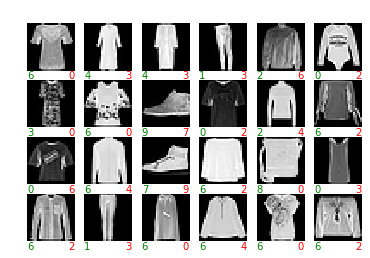

In [81]:
yhat_fashion_test = model.predict_classes(x_fashion_test)
labels = y_fashion_test.argmax(axis=1)

error_indices = np.where(yhat_fashion_test != labels)[0]

plot_some_samples(x_fashion_test, labels, yhat_fashion_test, error_indices);

The green digits are the true classes of the fashion items and the red digits are the predictions of our network.

Answer to question 10:

In [83]:
# TODO: Answer Question

## Exercise 3: One hidden layer, different optizimizers & overfitting (10 points)

### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 128 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to display your model in a compact way. (1 pt)
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent (SGD). (1pt)
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam). (1pt)
4. Plot the learning curves of SGD with a reasonable learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot. (2pts)
5. Answer the questions below. (4pts)
6. Run the network (using the Adam optimizer) on the Fashion-MNIST dataset and plot the learning curves using the plot_history function defined above. (1pt)

### Solution

In [17]:
# This plotting routine might help you ...
def comparison_plot(history_sgd, history_adam, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    ax1.plot(history_sgd.history['loss'], label=label1 + ' training')
    ax1.plot(history_sgd.history['val_loss'], label=label1 + ' validation')
    ax1.plot(history_adam.history['loss'], label=label2 + ' training')
    ax1.plot(history_adam.history['val_loss'], label=label2 + ' validation')
    ax2.plot(history_sgd.history['acc'], label=label1 + ' training')
    ax2.plot(history_sgd.history['val_acc'], label=label1 + ' validation')
    ax2.plot(history_adam.history['acc'], label=label2 + ' training')
    ax2.plot(history_adam.history['val_acc'], label=label2 + ' validation')
    finalize_standardplot(fig, ax1, ax2)
    return fig

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence each (double click this markdown cell to edit).

**Answer**:

A)

B)

**Question**: At which epoch (approximately) does the Adam optimizer start to overfit (on MNIST)? Please answer with one full sentence.

**Answer**:

**Question**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**:

## Exercise 4: Model performance as a function of number of hidden neurons (8 points)

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models (e.g. 5) with different hidden layer sizes (between 10 and 1000 hidden neurons) to the MNIST dataset. You may use the Adam optimizer and a meaningful number of epochs (overfitting!). (3 pts)
2. Plot the best validation loss and accuracy versus the number of hidden neurons. Is the observed trend in accordance with the [general approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)? If not, what might be practical reasons for the deviation? (2 sentences max.) (3 pts)
3. Repeat steps 1. & 2. for the Fashion-MNIST dataset. (2 pts)

In this exercise we fit each model only for one initialization and random seed. In practice one would collect some statistics (e.g. 25-, 50-, 75-percentiles) for each layer size by fitting each model several times with different initializations and the random seeds. You may also want to do this here. It is a good exercise, but not mandatory as it takes quite a bit of computation time.

### Solution

Answer to question 2:

## Exercise 5: Going deeper: tricks and regularization (8 points)

### Description

Adding hidden layers to a deep network does not necessarily lead to a straight-forward improvement of performance. Overfitting can be counteracted with regularization and dropout. Batch normalization is supposed to mainly speed up convergence. Since the MNIST dataset is almost perfectly solved already by a one-hidden-layer network we use the Fashion-MNIST dataset in this exercise.

1. Add one or two hidden layers with 50 hidden neurons (each) and train the network for a sufficiently long time (at least 100 epochs). Since deep models are very expressive you will most probably encounter overfitting. Try to improve the best validation scores of the model (even if it is only a minor improvement) by experimenting with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases. (4 pts)
2. After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized), preferably together in a comparison plot. Discuss your results; refer to the model performance with only 1 hidden layer. (2 sentences max.) (2pts)
3. Fit your best performing (probably regularized deep) model also to MNIST for having a reference for the next exercise. Plot the resulting learning curves. (2 pts)

### Solution

Answer to question 2 (comments):

## Exercise 6: Convolutional neural networks (CNNs) (10 points)

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with different architectures and parameters. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples). (4 pts)
2. Plot the learning curves of the convolutional neural network for MNIST and Fashion-MNIST. (4 pts)
3. How does the CNN performance compare to the so far best performing (deep) neural network model for the two data sets? (2 sentences max.) (2 pts)

### Solution

Answer to question 3:

## Exercise 7: Sigmoidal activation function and batch-normalization (6 points)

### Description:

In the original publication of batch normalization [Ioffe and Szegedy, 2014](https://arxiv.org/pdf/1502.03167.pdf), the authors mention a particularly beneficial effect of their method on networks with sigmoidal activation functions. This is because such networks usually suffer from saturating activations/vanishing gradients. Here we want to reproduce this behaviour (Chose either MNIST or Fashion-MNIST for this exercise).

1. Implement the same convolutional network as in the previous exercise, but using the sigmoid activation function instead of the standard choice ReLU. Train the network for a reasonable amount of time. What do you observe? (1 sentence max.) (3 pts)
2. Add batch-normalization layers to all convolutional and fully-connected layers (i.e. before each layer with learnable parameters). How does the performance change? Can the network reach the ReLU-CNN performance of the previous exercise? (1 sentence max.) (3 pts)
3. **BONUS (optional, not graded**): Investigate our initial guess that saturating activity/vanishing gradients might be the cause of this behaviour. For that, create histograms of the hidden activitions for different hidden layers for the sigmoid-CNN and the sigmoid-CNN with batch-normalization (counting over both, samples and neurons per layer). You may only chose layers with learnable parameters. What do you observe?
Hint: You can use the [keract](https://github.com/philipperemy/keract) package to access neural activation values for all layers of your network model.



### Solution:

Answer to question 1:

Answer to question 2: